In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import scipy.stats as stats
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [9]:
# testing file
file = xr.open_dataset('/Users/victoriaford/Downloads/CWOP_AP153.nc') # has flagged vars
# file = xr.open_dataset('/Users/victoriaford/Downloads/ASOSAWOS_72053900165.nc') # longer record, fewer flag vars
df = file.to_dataframe()
df = df.reset_index() 
df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable
df

,station,time,tas,hurs,sfcWind,sfcWind_dir,ps_altimeter,tas_qc,sfcWind_qc,tdps_derived,ps_derived,elevation,lat,lon,month,year
0,CWOP_AP153,2003-09-16 16:30:00,283.16,53.0,0.00,289.0,NaN,nan,nan,273.93,NaN,1406.0424,41.543,-120.5332,9,2003
1,CWOP_AP153,2003-09-16 17:00:00,284.83,44.0,0.90,263.0,NaN,nan,nan,272.88,NaN,1406.0424,41.543,-120.5332,9,2003
2,CWOP_AP153,2003-09-16 17:30:00,287.05,39.0,5.36,305.0,NaN,nan,nan,273.22,NaN,1406.0424,41.543,-120.5332,9,2003
3,CWOP_AP153,2003-09-16 18:00:00,287.61,37.0,4.47,296.0,NaN,nan,nan,273.00,NaN,1406.0424,41.543,-120.5332,9,2003
4,CWOP_AP153,2003-09-16 18:30:00,288.72,35.0,3.13,254.0,NaN,nan,nan,273.22,NaN,1406.0424,41.543,-120.5332,9,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8930,CWOP_AP153,2005-03-08 18:00:00,281.49,66.0,0.00,247.0,86725.20,nan,nan,275.44,73203.68,1406.0424,41.543,-120.5332,3,2005
8931,CWOP_AP153,2005-03-08 18:15:00,282.61,62.0,0.00,342.0,86725.20,nan,nan,275.62,73203.68,1406.0424,41.543,-120.5332,3,2005
8932,CWOP_AP153,2005-03-08 18:30:00,283.72,60.0,0.00,224.0,86725.20,nan,nan,276.20,73203.68,1406.0424,41.543,-120.5332,3,2005
8933,CWOP_AP153,2005-03-08 20:15:00,290.38,35.0,0.90,349.0,86639.45,nan,nan,274.70,73131.30,1406.0424,41.543,-120.5332,3,2005


In [10]:
def nice_plot_scatter(df, var):
    # ideally would plot using the eraqc column as color -- need to find a way to add a color for nan values
    df_good = df.loc[df[var+'_eraqc'] != 18]
    df_bad = df.loc[df[var+'_eraqc'] == 18]
    
    ax = df_good.plot.scatter(x='time', y=var, figsize=(9,2), s=1, color='k', label='Pass') 
    df_bad.plot.scatter(x='time', y=var, figsize=(9,2), s=1, color='r', label='Flagged', ax=ax) 

In [11]:
def iqr_standardize(df, var):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    
    return (df[var].values - df[var].median()) / iqr

In [12]:
def qaqc_dist_gaps_part1(df):
    """
    Part 1 / monthly check
        - compare anomalies of monthly median values
        - standardize against interquartile range
        - compare stepwise from the middle of the distribution outwards
        - asymmetries are identified and flagged if severe
    Goal: identifies individual suspect observations and flags the entire month  
    """
    
    # in order to grab the time information more easily -- would prefer not to do this
    df = df.reset_index() 
    df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
    df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable
    
    # calculate monthly medians
    df_anom = df.sub(df.resample('M', on='time').transform('median', numeric_only=True))
    df_anom['time'] = df['time'] # add time column back in to do quantiles

    df_q1 = df_anom.resample('M', on='time').transform('quantile', 0.25, numeric_only=True)
    df_q3 = df_anom.resample('M', on='time').transform('quantile', 0.75, numeric_only=True)
    df_iqr = df_q3 - df_q1
    df_anom_iqr = df_anom / df_iqr
    
    # run through every var, excluding qaqc/duration/method vars
    vars_to_remove = ['index','station','qc', 'duration', 'method', 'lat', 'lon', 'elevation', 'time', 'month', 'year', 'sfcWind_dir'] # list of var substrings to exclude if present in var
    vars_to_check = [var for var in df.columns if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables
    
#     vars_to_check = ['tdps'] # testing
    
    for var in vars_to_check:
        # standardize against calendar-month IQR range
#         df_anom_iqr = iqr_standardize(df_anom, var)

        # add _eraqc column for each variable
        df[var+'_eraqc'] = np.nan # default value of nan

        # standardized anomalies are ranked (necessary?) and calculate median
        std_med = df_anom_iqr[var].median() 

        # add standardized anomaly median to IQR-standardized data
        df_std_med = df_anom_iqr + std_med
        df_std_med['time'] = df['time'] # add time columns back in... again
        df_std_med['year'] = df['year']
        df_std_med['month'] = df['month']

        # identify where any obs are +/- 5 IQR away from standardized anomaly median
        if len(df_std_med.loc[np.abs(df_std_med[var]) > 5]) != 0:

            bad_idxs = df_std_med.loc[np.abs(df_std_med[var]) > 5].index.tolist() # grab indices of suspect obs
            bad_df = df.iloc[bad_idxs] # creates df subset of all flagged obs
            unique_bad = bad_df[['year', 'month']].drop_duplicates() # returns a df of idx, year, month
            
            print('{0} suspicious {1} observations present across {2} months'.format(len(bad_idxs), var, len(unique_bad)))
                        
            for i in unique_bad.index:
                
                # identify all indices for months encapsulating suspect obs
                bad_obs_yr = unique_bad.iloc[unique_bad.index == i]['year'].values[0]
                bad_obs_mon = unique_bad.iloc[unique_bad.index == i]['month'].values[0]
                
                bad_obs_per_month = df.loc[(df['year'] == bad_obs_yr) & (df['month'] == bad_obs_mon)]
                all_idx_to_flag = bad_obs_per_month.index

                # flag all indices in full df from the flagged months
                for i in all_idx_to_flag: # flag all indices in those months
                    df.loc[df.index == i, var+'_eraqc'] = 18 # see era_qaqc_flag_meanings.csv # DOUBLE CHECK VALUE

        else:
            print('Part 1: PASS. All {} obs are within +/- 5 IQR range'.format(var))
                
    return df


In [13]:
test = qaqc_dist_gaps_part1(df)

Part 1: PASS. All tas obs are within +/- 5 IQR range
Part 1: PASS. All hurs obs are within +/- 5 IQR range
8 suspicious sfcWind observations present across 1 months
12 suspicious tdps_derived observations present across 4 months
20 suspicious ps_derived observations present across 5 months


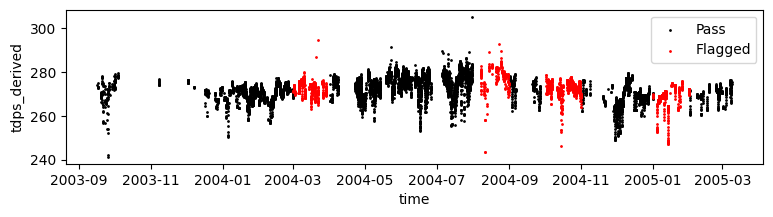

In [24]:
nice_plot_scatter(test, var='tdps_derived')

<Axes: xlabel='time', ylabel='tdps_derived'>

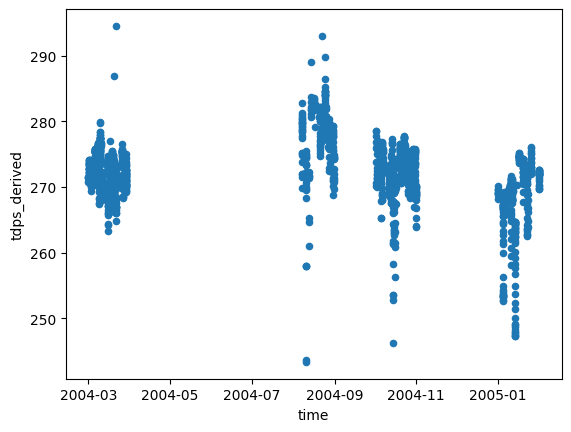

In [25]:
var = 'tdps_derived'
df_bad = test.loc[test[var+'_eraqc'] == 18]
df_bad.plot.scatter(x='time', y='tdps_derived')

In [26]:
df_bad_1m = df_bad.loc[(df_bad['year']==2004) & (df_bad['month']==3)]
# df_all_1m = df.loc[(df['year']==2004) & (df['month']==3)] # test grab all data from that month to check

In [32]:
df_bad_1m['tdps_derived'].median()

272.77

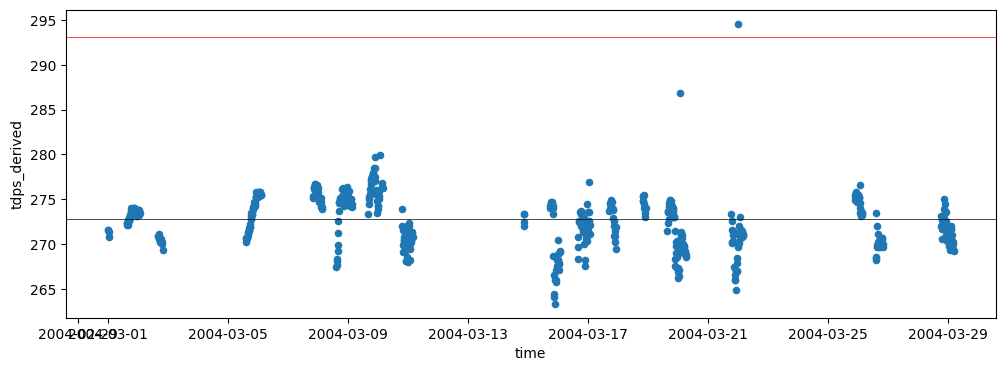

In [33]:
df_bad_1m.plot.scatter(x='time', y='tdps_derived', figsize=(12,4))
# df_all_1m.plot.scatter(x='time', y='tdps_derived', figsize=(12,4)) # is this all of the data? yes

plt.axhline(y=df_bad_1m['tdps_derived'].median(), color='k', linewidth=0.5)
top_5iqr = df_bad_1m['tdps_derived'].median() + iqr*5
plt.axhline(y=top_5iqr, color='r', linewidth=0.5)

In [29]:
q1 = df_bad_1m['tdps_derived'].quantile(0.25)
q3 = df_bad_1m['tdps_derived'].quantile(0.75)
iqr = q3-q1
iqr

4.064999999999941

In [ ]:
def plot_gap_scatter(df, var):
    
    yr_list = df['time'].dt.year.unique().tolist()
    num_yrs = len(yr_list)
    if num_yrs > 5:
        num_yrs = 3 # select specific years?
        
    # ideally would plot using the eraqc column as color -- need to find a way to add a color for nan values
    df_good = df.loc[df[var+'_eraqc'] != 18]
    df_bad = df.loc[df[var+'_eraqc'] == 18]
        
    month_fmt = DateFormatter('%b')
    def m_fmt(x, pos=None):
        return month_fmt(x)[0]  
    
    for yr in yr_list:    
        ax = df_good.loc[df['time'].dt.year == yr].plot.scatter(x='time', y=var, figsize=(6,2), s=1, color='k', label='Pass') 
        df_bad.loc[df_bad['time'].dt.year == yr].plot.scatter(x='time', y=var, figsize=(6,2), s=1, color='r', label='Flagged', ax=ax) 

        # what to do if one year of data has all nan values -- ex: sensor was added later on?
        ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
        ax.set_xlim(pd.Timestamp(str(yr)+'-01-01'), pd.Timestamp(str(yr)+'-12-31'))
        ax.set_ylim(int(df[var].min()), int(df[var].max())+1)
        ax.set_xlabel(yr) # for now
        
        # flagged/suspicious data in different color - need to overlap, not new axis
#         bad_vals = df.loc[df[var+'_eraqc'] == 18]
#         ax = bad_vals.loc[bad_vals['time'].dt.year == yr].plot.scatter(x='time', y=var, s=1, color='r', label='Flagged')


    # modify so that legend only appears once
    # legend item text size small, 2 cols


In [ ]:
plot_gap_scatter(df, var='tas')